<a href="https://colab.research.google.com/github/leakuidatorplusteam/artifacts/blob/main/cache_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input,Conv1D,MaxPool1D,LSTM,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from scipy.interpolate import make_interp_spline
from sklearn.metrics import mean_squared_error as mse
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import zipfile

In [ ]:
## Online-Only Attack Simulation
def online(Xdata,ydata):
  countmseT = 0
  countmseN = 0
  countdtwT = 0
  countdtwN = 0
  index = 0
  while(index < 100):
    b0 = Xdata[index+100] 
    b1 = Xdata[index]
    p0 = Xdata[index+101]
    p1 = Xdata[index+1]
    n = mse(b0,p0)
    t = mse(b1,p0)
    if(n < t):
      countmseN = countmseN + 1
    n = mse(b0,p1)
    t = mse(b1,p1)
    if(n >= t):
      countmseT = countmseT + 1
    n = fastdtw(b0,p0, dist=euclidean)
    t = fastdtw(b1,p0, dist=euclidean)
    if(n[0] < t[0]):
      countdtwN = countdtwN + 1
    n = fastdtw(b0,p1, dist=euclidean)
    t = fastdtw(b1,p1, dist=euclidean)
    if(n[0] >= t[0]):
      countdtwT = countdtwT + 1
    index = index + 2
  
  return str(countmseT+countmseN)+"%", str(countdtwT+countdtwN)+"%"

In [63]:
## LSTM model
def small_cnn_lstm(input_vector, output_size=2, filters=256, strides=3, pool_size=4, units=32, dropout=0.7, kernel_size=32, lr=0.001):
    inp = Input((input_vector, 1))
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, activation='relu')(inp)
    x = MaxPool1D(pool_size=pool_size, padding='same')(x)
    x = LSTM(units, return_sequences=True, recurrent_activation='hard_sigmoid')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    preds = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=inp, outputs=preds)
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # optimizer, metrics
    return model

In [ ]:
## methods include MSE, DTW, GNB, MNB, KNN, SVM, RF, LR and LSTM
def classify_binary(method, Xdata, ydata):
  lab_enc=LabelEncoder()
  lab_hot=OneHotEncoder()
  y_num= lab_enc.fit_transform(ydata)
  y_hot=lab_hot.fit_transform(y_num.reshape(-1,1))
  y_hot=y_hot.toarray()
  skf = StratifiedShuffleSplit(n_splits=10,random_state=6)

  partial_accuracies=[]
  for train_index, test_index in skf.split(Xdata, ydata):
      X_train, X_test = Xdata[train_index], Xdata[test_index]
      mean=X_train.mean()
      std=X_train.std()
      X_train_norm=(X_train-mean+1e-10)/std
      X_test_norm=(X_test-mean+1e-10)/std
  
      y_train, y_test = ydata[train_index], ydata[test_index]

      if(len(Xdata) > 100 and len(Xdata[0]) > 100):
        pca=PCA(n_components=100, svd_solver='randomized', whiten=True, random_state=6)

      ## MNB and GNB: Multinomial and Gaussian Naive Bayes
      if(method == 'GNB'):
        model = GaussianNB()
        model.fit(X_train,y_train)
        prd=model.predict(X_test)
      
      if(method == 'MNB'):
        model = MultinomialNB()
        model.fit(X_train,y_train)
        prd=model.predict(X_test)

      ## KNN: K Nearest Neighbor
      if(method == 'KNN'):
        knn=KNeighborsClassifier()
        param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']}
        grid= GridSearchCV(knn, param_grid,n_jobs=-1)
        grid.fit(X_train_norm,y_train)
        model=grid.best_estimator_
        prd=model.predict(X_test_norm)
      
      ## SVM: Support Vector Machine
      if(method == 'SVM'):
        svc = SVC(kernel='rbf',class_weight='balanced',random_state=6)
        if(len(Xdata) > 100 and len(Xdata[0]) > 100):
          model=make_pipeline(pca,svc)
          param_grid = {'svc__C': [1, 5, 10, 50],'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]} 
        else:
          model=svc
          param_grid = {'C': [1, 5, 10, 50],'gamma': [0.0001, 0.0005, 0.001, 0.005]} 
        grid = GridSearchCV(model, param_grid)
        grid.fit(X_train_norm, y_train)
        model = grid.best_estimator_
        prd=model.predict(X_test_norm)

      ## RF: Random Forest
      if(method == 'RF'):
        model = RandomForestClassifier(n_estimators=1000, random_state=6)
        model.fit(X_train_norm,y_train)
        prd=model.predict(X_test_norm)
      
      ## LR: Logistic Regression
      if(method == 'LR'):
        model=LogisticRegression(max_iter=1000)
        model.fit(X_train_norm,y_train)
        prd=model.predict(X_test_norm)

      ## LSTM: Long Short-Term Memory 
      if(method == 'LSTM'):
        y_train, y_test = y_hot[train_index], y_num[test_index]
        model=small_cnn_lstm(X_train.shape[1])
        model.fit(X_train_norm,y_train,validation_split=0.1,epochs=100,verbose=0,callbacks=[EarlyStopping( patience=2,restore_best_weights=True)])
        prd=model.predict(X_test_norm).argmax(axis=-1)

      ## record partial accuracies
      partial_accuracies.append(classification_report(y_test, prd, output_dict=True)['accuracy'])

  mean=round(np.mean(partial_accuracies)*100,2)
  deviation=round(np.std(partial_accuracies)*100,2)
  return (str(mean)+"%±"+str(deviation)+"%")

In [ ]:
## Average Plot
def average_plot(dataX, sweep, interval, duration):
  sample_size= len(dataX[0])

  arr0 = np.zeros(sample_size)
  arr1 = np.zeros(sample_size)

  count0 = np.zeros(sample_size)
  count1 = np.zeros(sample_size)
  
  for i in range(0,int(len(dataX)/2)):
    for j in range(0,sample_size):
      cond_val = 6.0
      if(sweep == True):
        cond_val = 0
      
      if(dataX[i+100][j] != cond_val):
        arr0[j] += dataX[i+100][j]
        count0[j] += 1
      if(dataX[i][j] != cond_val):
        arr1[j] += dataX[i][j]
        count1[j] += 1

  for i in range(0,sample_size):
    if(count0[i] != 0):
      arr0[i] /= count0[i]
      if(sweep == True and arr0[i] != 0):
        arr0[i] = interval/arr0[i]
    if(count1[i] != 0):
      arr1[i] /= count1[i]
      if(sweep == True and arr1[i] != 0):
        arr1[i] = interval/arr1[i]
  ydata= []
  for i in range(1,len(dataX[0])+1):
    ydata.append(i)
  ydata=np.array(ydata)
  plt.plot(arr0, '+--', label = "Non Target", linewidth=1, markersize=4,c="blue")
  plt.plot(arr1, 'o-', label = "Target", linewidth=1, markersize=4,c="orange",alpha=0.3)
  
  step=0.25
  plt.xticks(np.arange(0, sample_size+1, sample_size*step),[0,step*duration,step*2*duration,step*3*duration,step*4*duration])
  
  plt.xlabel("Time of Measurement (s)")
  plt.ylabel("Average Buffer Access Time (ms)")
  plt.legend()
  plt.show()

In [24]:
## using the classifiers
def classify(Xdata, ydata, class_type, df):
  if class_type == "binary":
    p_mse,p_dtw=online(Xdata,ydata)
    p_gnb=classify_binary('GNB', Xdata, ydata)
    p_mnb=classify_binary('MNB', Xdata, ydata)
    p_knn=classify_binary('KNN', Xdata, ydata)
    p_svm=classify_binary('SVM', Xdata, ydata)
    p_rf=classify_binary('RF', Xdata, ydata)
    p_lr=classify_binary('LR', Xdata, ydata)
    #p_lstm=classify_binary('LSTM', Xdata, ydata)
    return df + "; MSE: " + str(p_mse) + ", FastDTW: " + str(p_dtw) + ", GNB: " + str(p_gnb) + ", MNB: " + str(p_mnb) + ", KNN: " + str(p_knn) + ", SVM: " + str(p_svm) + ", RF: " + str(p_rf) + ", LR: " + str(p_lr) #+ " LSTM: " + str(p_lstm)
  #else:
  #  p_lstm=classify_multi('LSTM', Xdata, ydata)


In [ ]:
## load the dataset
## TODO: add all traces to the dataset
!wget "https://github.com/leakuidatorplusteam/artifacts/raw/main/dataset.zip" # type: ignore

with zipfile.ZipFile("dataset.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
## [Single Target Attacks (Table 2 of the paper)]
systems=["Win-Chrome", "Win-Tor", "Mac-Intel-Safari", "Mac-M1-Chrome"]
services=["Google", "Twitter", "LinkedIn", "TikTok", "Facebook", "Instagram", "Reddit"]
defense=["w_o_def","w_def"]
for m in systems:
  for s in services:
    setup=m + '-' + s
    print("\n")
    print(setup)
    for d in defense:
      if(m=="Mac-Intel-Safari" and d=="w_def"):
        continue
      path= setup + '-' + d + ".json"
      with open("dataset/"+path,'r') as f:
        data=json.load(f)
      X=np.array(data['X'],dtype=np.float32)
      y=np.array(data['y'])
      print(classify(X, y, "binary",d))



Win-Chrome-Google
w_o_def; MSE: 97%, FastDTW: 98%, GNB: 98.0%±2.45%, MNB: 98.0%±2.45%, KNN: 98.5%±2.29%, SVM: 98.0%±2.45%, RF: 98.5%±2.29%, LR: 98.0%±2.45%
w_def; MSE: 49%, FastDTW: 50%, GNB: 54.0%±8.31%, MNB: 56.5%±10.01%, KNN: 55.0%±10.72%, SVM: 49.5%±12.93%, RF: 60.0%±12.04%, LR: 54.0%±14.63%


Win-Chrome-Twitter
w_o_def; MSE: 76%, FastDTW: 82%, GNB: 97.5%±2.5%, MNB: 97.0%±4.58%, KNN: 97.0%±3.32%, SVM: 97.5%±4.61%, RF: 98.0%±3.32%, LR: 98.0%±3.32%
w_def; MSE: 55%, FastDTW: 53%, GNB: 53.5%±7.09%, MNB: 46.5%±11.41%, KNN: 53.5%±13.79%, SVM: 45.0%±13.23%, RF: 49.0%±9.17%, LR: 41.0%±15.62%


Win-Chrome-LinkedIn
w_o_def; MSE: 100%, FastDTW: 100%, GNB: 97.5%±3.35%, MNB: 98.0%±3.32%, KNN: 100.0%±0.0%, SVM: 98.5%±2.29%, RF: 99.5%±1.5%, LR: 100.0%±0.0%
w_def; MSE: 47%, FastDTW: 45%, GNB: 51.0%±11.14%, MNB: 54.5%±9.6%, KNN: 52.0%±6.4%, SVM: 52.0%±6.0%, RF: 55.0%±7.75%, LR: 55.0%±7.75%


Win-Chrome-TikTok
w_o_def; MSE: 67%, FastDTW: 69%, GNB: 77.5%±7.83%, MNB: 75.5%±7.57%, KNN: 80.0%±5.48%, S

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

w_def; MSE: 47%, FastDTW: 47%, GNB: 40.0%±10.0%, MNB: 51.5%±9.76%, KNN: 44.5%±9.86%, SVM: 47.0%±8.43%, RF: 52.0%±9.0%, LR: 45.0%±10.95%


Win-Tor-Google
w_o_def; MSE: 65%, FastDTW: 80%, GNB: 91.0%±6.63%, MNB: 90.0%±6.32%, KNN: 83.0%±5.57%, SVM: 90.0%±7.75%, RF: 91.0%±7.0%, LR: 91.0%±5.83%
w_def; MSE: 48%, FastDTW: 54%, GNB: 46.0%±8.0%, MNB: 47.5%±9.01%, KNN: 46.5%±11.84%, SVM: 48.0%±10.54%, RF: 49.0%±12.21%, LR: 47.0%±6.78%


Win-Tor-Twitter
w_o_def; MSE: 71%, FastDTW: 74%, GNB: 95.5%±4.72%, MNB: 94.5%±4.15%, KNN: 91.0%±3.0%, SVM: 97.0%±3.32%, RF: 95.5%±3.5%, LR: 95.0%±4.47%
w_def; MSE: 52%, FastDTW: 43%, GNB: 46.0%±9.43%, MNB: 46.0%±9.95%, KNN: 55.0%±10.95%, SVM: 51.5%±10.97%, RF: 41.5%±7.76%, LR: 47.5%±9.29%


Win-Tor-LinkedIn
w_o_def; MSE: 52%, FastDTW: 54%, GNB: 79.5%±10.36%, MNB: 80.0%±7.42%, KNN: 69.5%±11.93%, SVM: 83.5%±7.76%, RF: 80.0%±7.75%, LR: 84.5%±6.1%
w_def; MSE: 53%, FastDTW: 52%, GNB: 38.0%±5.1%, MNB: 42.0%±9.54%, KNN: 48.0%±7.48%, SVM: 39.5%±8.2%, RF: 41.0%±5.83%, LR: 

In [ ]:
## [Chrome Android]
setup = "Android-Chrome-Google"
print(setup)
d="w_o_def"
path= setup + '-' + d + ".json"
with open("dataset/"+path,'r') as f:
  data=json.load(f)
X=np.array(data['X'],dtype=np.float32)
y=np.array(data['y'])
print(classify(X, y, "binary",d))

Android-Chrome-Google
w_o_def; MSE: 59%, FastDTW: 67%, GNB: 54.5%±11.06%, MNB: 88.5%±9.23%, KNN: 66.0%±5.83%, SVM: 88.0%±8.43%, RF: 86.5%±7.76%, LR: 92.0%±4.58%


In [ ]:
## [Old Defense (Leakuidator)]
setup = "Win-Chrome-Google"
print(setup)
d="w_old_def"
path= setup + '-' + d + ".json"
with open("dataset/"+path,'r') as f:
  data=json.load(f)
X=np.array(data['X'],dtype=np.float32)
y=np.array(data['y'])
print(classify(X, y, "binary",d))

Win-Chrome-Google
w_old_def; MSE: 61%, FastDTW: 69%, GNB: 88.0%±5.1%, MNB: 85.0%±5.0%, KNN: 83.0%±4.58%, SVM: 87.0%±4.0%, RF: 86.0%±5.83%, LR: 88.5%±4.5%


In [ ]:
### TODO: [Experiments under noise]

In [70]:
def classify_multi(X,y,d):
    lab_enc=LabelEncoder()
    lab_hot=OneHotEncoder()
    y_num= lab_enc.fit_transform(y)
    y_hot=lab_hot.fit_transform(y_num.reshape(-1,1))
    y_hot=y_hot.toarray()

    skf = StratifiedShuffleSplit(n_splits=10,random_state=6)
    acc_mean=0
    acc_dev=0
    acc_partial=[]
    preds=[]
    true=[]
    for train_index, test_index in skf.split(X, y_num):
        X_train, X_test = X[train_index], X[test_index]
        mean=X_train.mean()
        std=X_train.std()
        X_train_norm=(X_train-mean+1e-10)/std
        X_test_norm=(X_test-mean+1e-10)/std

        y_train, y_test = y_hot[train_index], y_num[test_index]
        length=X_train.shape[1]
        model=small_cnn_lstm(X_train.shape[1],output_size=8)
        model.fit(X_train_norm,y_train,validation_split=0.1,epochs=100,verbose=2,callbacks=[EarlyStopping( patience=2,restore_best_weights=True)])
        preds.extend( model.predict(X_test_norm).argmax(axis=-1))
        true.extend(y_test)
        prd=model.predict(X_test_norm).argmax(axis=-1)
        acc_partial.append(classification_report(y_test, prd, output_dict=True)['accuracy'])
    
    acc_mean = np.mean(acc_partial)
    acc_dev = np.std(acc_partial)
    print(d + "mean: ",acc_mean," std: ", acc_dev)
    print(classification_report(true, preds))

In [78]:
### TODO: [Multi Target Attacks]
systems=["Win-Chrome-LinkedIn", "Win-Tor-YouTube", "Mac-Safari-Twitter"]
defense=["w_o_def","w_def"]
states = ["0","1","2","3","4","5","6","7"]
path=[]
data=[]
X=[]
y=[]
print(systems[1])
for st in states:
  path=systems[1] + '-' + defense[0] + '_' + st + ".json"
  with open(path,'r') as f:
    data=json.load(f)
    X_data=np.array(data['X'],dtype=np.float32)
    y_data=np.array(data['y'])
    X= np.array([y for x in [X_data, X] for y in x],dtype=np.float32)
    y= np.array([y for x in [y_data, y] for y in x],dtype=np.float32)
print(classify_multi(X, y,d))

Win-Tor-YouTube
w_o_def mean:  0.7675  std:  0.04301162633521313
              precision    recall  f1-score   support

           0       0.71      0.90      0.80       100
           1       0.81      0.81      0.81       100
           2       0.85      0.75      0.80       100
           3       0.74      0.71      0.72       100
           4       0.75      0.80      0.78       100
           5       0.79      0.74      0.76       100
           6       0.73      0.76      0.75       100
           7       0.78      0.67      0.72       100

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800

None


In [18]:
def average_plot(X, sweep, interval, duration):
  sample_size= len(X[0])
  arr0 = np.zeros(sample_size)
  arr1 = np.zeros(sample_size)
  count0 = np.zeros(sample_size)
  count1 = np.zeros(sample_size)
  for i in range(0,100):
    for j in range(0,sample_size):
      cond_val = 6.0
      if(sweep == True):
        cond_val = 0
      if(X[i][j] != cond_val):
        arr0[j] += X[i][j]
        count0[j] += 1
      if(X[i+100][j] != cond_val):
        arr1[j] += X[i+100][j]
        count1[j] += 1
  for i in range(0,sample_size):
    if(count0[i] != 0):
      arr0[i] /= count0[i]
      if(sweep == True and arr0[i] != 0):
        arr0[i] = interval/arr0[i]
    if(count1[i] != 0):
      arr1[i] /= count1[i]
      if(sweep == True and arr1[i] != 0):
        arr1[i] = interval/arr1[i]
  ydata= []
  for i in range(1,101):
    ydata.append(i)
  ydata=np.array(ydata)
  plt.plot(arr1, '+--', label = "Non Target", linewidth=1, markersize=4,c="blue")
  plt.plot(arr0, 'o-', label = "Target", linewidth=1, markersize=4,c="orange",alpha=0.3)
  step=0.25
  plt.xticks(np.arange(0, sample_size+1, sample_size*step),[0,step*duration,step*2*duration,step*3*duration,step*4*duration])
  plt.xlabel("Time of measurement (s)")
  plt.ylabel("Average buffer access time (ms)")
  plt.legend()
  plt.show()

In [20]:
# LR with 10-fold cross validation
def accuracy_plot(X, y, duration):
  skf = StratifiedShuffleSplit(n_splits=10,random_state=6)
  means=[]
  deviations=[]
  X_temp = X
  ss = len(X[0])
  for datapoint_index in range (1,ss+1):
    X_temp = np.delete(X,np.s_[datapoint_index:ss],axis=1)
    partial_accuracies=[]
    for train_index, test_index in skf.split(X_temp, y):
      X_train, X_test = X_temp[train_index], X_temp[test_index]
      mean=X_train.mean()
      std=X_train.std()
      X_train_norm=(X_train-mean+1e-10)/std
      X_test_norm=(X_test-mean+1e-10)/std
  
      y_train, y_test = y[train_index], y[test_index]
      length=X_train.shape[1]
  
      logreg = LogisticRegression(max_iter=1000)
      logreg.fit(X_train_norm,y_train)
      prd=logreg.predict(X_test_norm);
      partial_accuracies.append(classification_report(y_test, prd, output_dict=True)['accuracy'])
    means.append(np.mean(partial_accuracies))
    deviations.append(np.std(partial_accuracies))
  xdata=np.array(means);
  stdata=np.array(deviations)
  ydata= []
  steps = 0.002
  for i in range(1,len(xdata)+1):
    ydata.append(i*steps)
  ydata=np.array(ydata)
  plt.plot(xdata, label = 'Accuracy')
  plt.fill_between(ydata*ss, xdata - stdata, xdata + stdata, color='gray', alpha=0.2, label = 'std')
  plt.xticks(np.arange(0, ss+1, step=ss/4),[0,(duration/4),(duration/2),(duration/4)*3,duration])
  plt.xlabel("Time of measurement included (s)")
  plt.ylabel("Attack accuracy")
  ax = plt.gca()
  ax.set_ylim(bottom=0.3)
  ax.set_ylim(top=1)
  plt.legend()
  plt.savefig('youtube-classifier-vs-time.pdf', dpi=300)
  plt.show()

Win-Chrome-Google-w_o_def


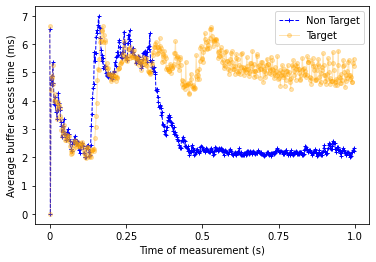

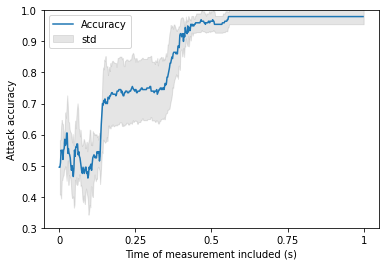

In [22]:
## [Average and Attack Accuracy plots]
## Setups
systems=["Win-Chrome", "Win-Tor", "Mac-Intel-Safari", "Mac-M1-Chrome"]
services=["Google", "Twitter", "LinkedIn", "TikTok", "Facebook", "Instagram", "Reddit"]
defense=["w_o_def","w_def"]
setup= systems[0]+ '-' + services[0] + '-' + defense[0]
with open("dataset/"+setup+".json",'r') as f:
  data=json.load(f)
X=np.array(data['X'],dtype=np.float32)
y=np.array(data['y'])
print(setup)
average_plot(X, sweep=False, interval=2, duration=1)
accuracy_plot(X, y, 1)